TODO:
- Choose another architecture for the dataset Maybe without <BOS> and <EOS>
- Include the prompts as a guidance maybe in the decoding process add a channel with the prompt for the next layer (Add a "end" prompt to indicate that the generation is over ?)
- Transfer to github


In [1]:
# Import necessary libraries
import numpy as np
import time
import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm
import wandb

# Import custom modules
from models.AutoregressiveCNNGenerator import AutoregressiveCNNGenerator
from loss.RGBAMSELoss import RGBAWeightedProportionalMSELoss

# Import functions
from data_loaders.data_loaders import get_loaders
from utils.utils_functions import *

# Import constants
from constants import *

### Training function

In [ ]:
def train_model(dataset_path, output_dir, checkpoint_path=None, batch_size=32, num_epochs=50, lr=0.001):
    """
    Train the autoregressive RGBA character generator model with pre-processed PyTorch data.
    
    Args:
        dataset_path: Path to the PyTorch dataset file
        output_dir: Directory to save outputs
        batch_size: Batch size for training
        num_epochs: Number of epochs to train
        lr: Learning rate
    """
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Get dataloaders with fast loading
    print("Loading dataset...")
    data_loading_start = time.time()
    train_loader, val_loader = get_loaders(
        dataset_path,
        batch_size=batch_size
    )
    data_loading_time = time.time() - data_loading_start
    print(f"Dataset loaded in {data_loading_time:.2f}s")
    print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}")
    
    # Initialize model
    model = AutoregressiveCNNGenerator().to(device)
    if checkpoint_path:
        # Load model from checkpoint if provided
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"Model loaded from epoch {checkpoint['epoch']}, Train Loss: {checkpoint['train_loss']:.6f}, Val Loss: {checkpoint['val_loss']:.6f}")
    
    # Loss function and optimizer
    criterion = RGBAWeightedProportionalMSELoss(threshold=0.05, alpha_channel_weight=2.0)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Creating WandB run
    print("Creating WandB run...")
    run = wandb.init(entity="quentinlca-perso",  # Replace with your WandB entity
                     project="DTU-internship",
                     name="train_autoregressive_rgba_generator",
                     config={
                        "model_name": model.__class__.__name__,
                        "loss_function": {
                            'name': criterion.__class__.__name__,
                            'params': list(criterion.parameters()),
                        },
                        "optimizer": optimizer.__class__.__name__,
                        "device": str(device),
                        "checkpoint_path": checkpoint_path if checkpoint_path else "None",
                        "dataset": os.path.basename(dataset_path),
                        "dataset_size": len(train_loader.dataset) + len(val_loader.dataset),
                        "batch_size": batch_size,
                        "num_epochs": num_epochs,
                        "learning_rate": lr
                     })
    
    # Training loop
    train_losses = []
    val_losses = []
    total_train_time = 0
    
    total_epoch = checkpoint['epoch'] if checkpoint_path else 0
    last_epoch = total_epoch + num_epochs
    print("Resuming training from epoch:", total_epoch + 1)
    for epoch in range(num_epochs):
        total_epoch += 1
        epoch_start = time.time()
        print(f"\nEpoch {total_epoch}/{last_epoch}")
        
        # Training phase
        model.train()
        train_loss = 0.0
        
        for inputs, targets in tqdm(train_loader, desc="Training"):
            # Move data to device
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            
            # Calculate loss
            loss = criterion(inputs, outputs, targets)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        # Average training loss
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        
        with torch.no_grad():
            for inputs, targets in tqdm(val_loader, desc="Validating"):
                # Move data to device
                inputs = inputs.to(device)
                targets = targets.to(device)
                
                # Forward pass
                outputs = model(inputs)  # No layer_idx needed for validation
                
                # Calculate loss
                loss = criterion(inputs, outputs, targets)
                val_loss += loss.item()
                
                # Save the first batch for visualization
                if epoch % 5 == 0 and val_loss == loss.item():
                    example_inputs = inputs
                    example_targets = targets
                    example_outputs = outputs
        
        # Average validation loss
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        epoch_time = time.time() - epoch_start
        total_train_time += epoch_time
        
        print(f"Epoch {total_epoch} - Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")
        print(f"Epoch time: {epoch_time:.2f}s")
        
        # Save model checkpoint
        if (epoch) % 10 == 0 or epoch == num_epochs - 1:
            print(f"Saving checkpoint for epoch {total_epoch}...")
            torch.save({
                'epoch': total_epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': train_loss,
                'val_loss': val_loss,
            }, os.path.join(output_dir, f'checkpoint_epoch_{total_epoch}.pt'))
        
        # Visualize results every 5 epochs
        if epoch % 5 == 0 or epoch == num_epochs - 1:
            print("Saving example images...")
            save_examples(example_inputs, 
                          example_targets, 
                          example_outputs, 
                          f"{output_dir}/results_epoch_{total_epoch}")
        # Log to WandB
        print("Logging to WandB...")
        run.log({
            "epoch": total_epoch,
            "train_loss": train_loss,
            "val_loss": val_loss,
            "epoch_time": epoch_time,
            "total_train_time": total_train_time
        })
    
    # Plot loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.savefig(os.path.join(output_dir, 'loss_curve.png'))
    
    # Generate and save a full sequence
    # generate_full_rgba_sequence(model, device, os.path.join(output_dir, 'full_sequence.png'))
    
    avg_epoch_time = total_train_time / num_epochs
    print(f"Training completed. Results saved to {output_dir}")
    print(f"Total training time: {total_train_time:.2f}s, Average epoch time: {avg_epoch_time:.2f}s")
    
    run.finish()
    return model

### Main Cell

Using device: cuda
Loading dataset...
Dataset loaded in 26.52s
Train batches: 479, Val batches: 120


wandb: Currently logged in as: quentinlca (quentinlca-perso) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Resuming training from epoch: 1

Epoch 1/10


Validating: 100%|██████████| 120/120 [00:24<00:00,  4.87it/s]


Epoch 1 - Train Loss: 0.048765, Val Loss: 0.020502
Epoch time: 250.84s

Epoch 2/10


Validating: 100%|██████████| 120/120 [00:22<00:00,  5.30it/s]


Epoch 2 - Train Loss: 0.018637, Val Loss: 0.018305
Epoch time: 200.05s

Epoch 3/10


Validating: 100%|██████████| 120/120 [00:25<00:00,  4.76it/s]


Epoch 3 - Train Loss: 0.017092, Val Loss: 0.016563
Epoch time: 195.49s

Epoch 4/10


Validating: 100%|██████████| 120/120 [00:26<00:00,  4.54it/s]


Epoch 4 - Train Loss: 0.016503, Val Loss: 0.017194
Epoch time: 197.45s

Epoch 5/10


Validating: 100%|██████████| 120/120 [00:23<00:00,  5.21it/s]


Epoch 5 - Train Loss: 0.016345, Val Loss: 0.016485
Epoch time: 194.93s

Epoch 6/10


Validating: 100%|██████████| 120/120 [00:23<00:00,  5.13it/s]


Epoch 6 - Train Loss: 0.015720, Val Loss: 0.015647
Epoch time: 194.99s

Epoch 7/10


Validating: 100%|██████████| 120/120 [00:22<00:00,  5.26it/s]


Epoch 7 - Train Loss: 0.015443, Val Loss: 0.015204
Epoch time: 200.26s

Epoch 8/10


Validating: 100%|██████████| 120/120 [00:24<00:00,  4.88it/s]


Epoch 8 - Train Loss: 0.015208, Val Loss: 0.015277
Epoch time: 194.14s

Epoch 9/10


Validating: 100%|██████████| 120/120 [00:23<00:00,  5.19it/s]


Epoch 9 - Train Loss: 0.015181, Val Loss: 0.015125
Epoch time: 195.20s

Epoch 10/10


Validating: 100%|██████████| 120/120 [00:32<00:00,  3.66it/s]


Epoch 10 - Train Loss: 0.015094, Val Loss: 0.015905
Epoch time: 206.06s
Training completed. Results saved to training_output
Total training time: 2029.40s, Average epoch time: 202.94s


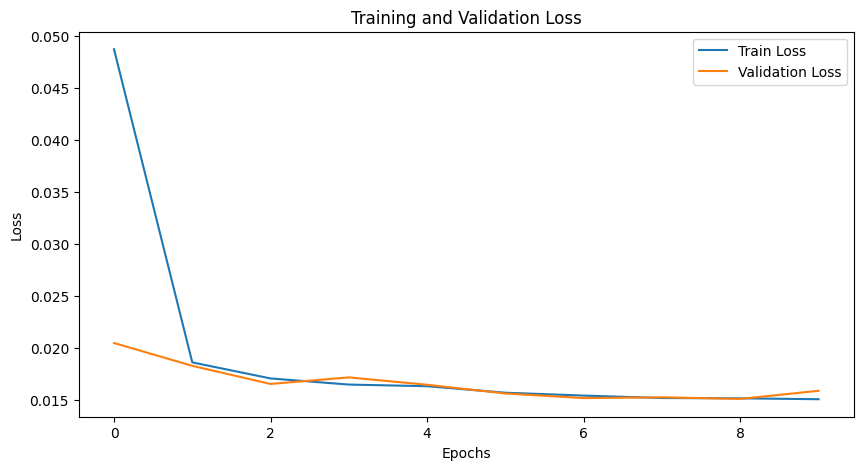

In [8]:
model = train_model(
    dataset_path='tensor_dataset/dataset.pt',  # Replace with your dataset path
    output_dir='training_output',  # Replace with your desired output directory
    checkpoint_path=None,  # Optional: Load from a checkpoint
    batch_size=32,
    num_epochs=10,
    lr=0.001
)